## XG Boost regression model using return as the target

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, r2_score, mean_squared_error, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb

In [ ]:
df = pd.read_csv("Preprocessed_Data_with_features.csv")

Test MSE: 0.000129
Test R² Score: -1.2128

Sample of Actual vs Predicted Returns:
     Actual  Predicted
0 -0.007414   0.004076
1  0.000000   0.001478
2  0.000000   0.003071
3  0.001737   0.003713
4  0.001997   0.005642
5  0.006091   0.003158
6  0.002599   0.000116
7  0.002962   0.002770
8  0.000000   0.001776
9  0.000000  -0.002311

Model Interpretation:
The model performs poorly. It may be underfitting or important features might be missing.


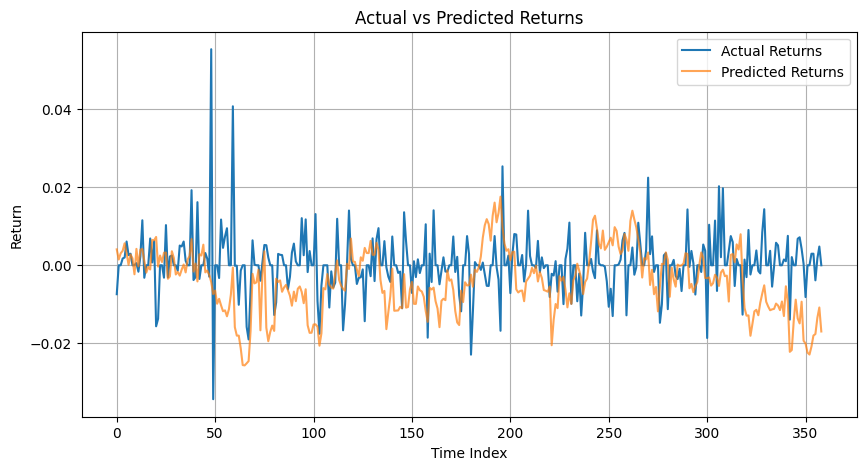

In [ ]:
# Define features by dropping columns that leak target or are not features
features = df.drop(columns=['Date', 'Price', 'Return', 'Direction'])

# Target is the continuous return value
target = df['Return']

# Split data into train (80%) and test (20%) sets without shuffling (time series!)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(features, target, test_size=0.2, shuffle=False)

# Initialize XGBoost regressor with 100 trees and squared error objective
model_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Train the model on training data
model_reg.fit(X_train, y_train_reg)

# Predict returns on test data
y_pred_reg = model_reg.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"Test MSE: {mse:.6f}")
print(f"Test R² Score: {r2:.4f}")

#Show first few actual vs predicted values
comparison = pd.DataFrame({'Actual': y_test_reg.values, 'Predicted': y_pred_reg})
print("\nSample of Actual vs Predicted Returns:")
print(comparison.head(10))

# Interpretation
print("\nModel Interpretation:")
if r2 > 0.7:
    print("The model explains a large portion of the variance in the target variable. Predictions are likely reliable.")
elif r2 > 0.4:
    print("The model has moderate predictive power. Consider tuning hyperparameters or feature engineering.")
else:
    print("The model performs poorly. It may be underfitting or important features might be missing.")

#Visualization
plt.figure(figsize=(10, 5))
plt.plot(y_test_reg.values, label='Actual Returns')
plt.plot(y_pred_reg, label='Predicted Returns', alpha=0.7)
plt.title("Actual vs Predicted Returns")
plt.xlabel("Time Index")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()


## Metrics Summary:

MSE: 0.000129 — This seems small, but it's relative to the scale of your target variable (returns), which are themselves very small values.

R² Score: -1.2128 — A negative R² means the model performs worse than a horizontal line (i.e. simply predicting the mean return).

## What the Plot Shows:
From the plot and values:

The predicted returns are smoother and lag behind the actual ones — indicating the model may be overly conservative or failing to capture short-term volatility.

There's a systematic underperformance, especially in higher volatility zones (e.g., large spikes in actual returns aren't matched by predicted ones).

These features are derived from price, so there might be high multicollinearity (redundant information).

Short prediction horizon (next-day return) is inherently noisy and hard to predict deterministically.

The target (Return) is continuous and small, making errors relatively more impactful on R².

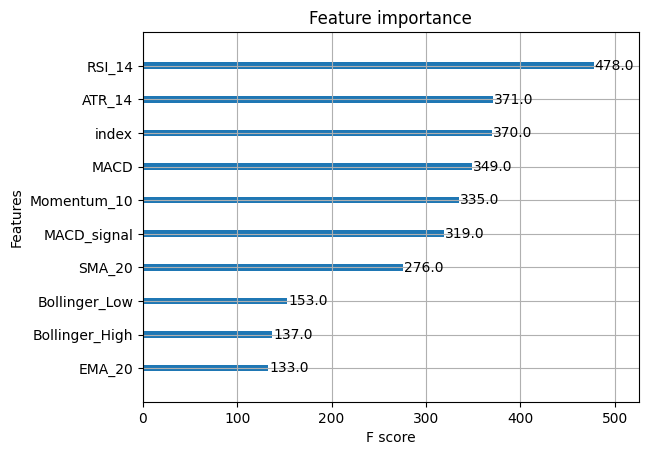

In [ ]:
#Check feature importance
xgb.plot_importance(model_reg, max_num_features=10)
plt.show()

The model places strong emphasis on momentum and volatility indicators, which is expected for short-term return prediction.

Despite this, the low recall and F1 scores suggest that even the most important features might not capture enough signal-to-noise ratio for reliable classification.

The fact that EMA and Bollinger Bands rank low could mean they’re either too lagging or redundant with other features.


📊 Evaluation Metrics for XGBoost Regression
Test MSE         : 0.000129
Sharpe Ratio     : 0.2027
Max Drawdown     : -0.1163


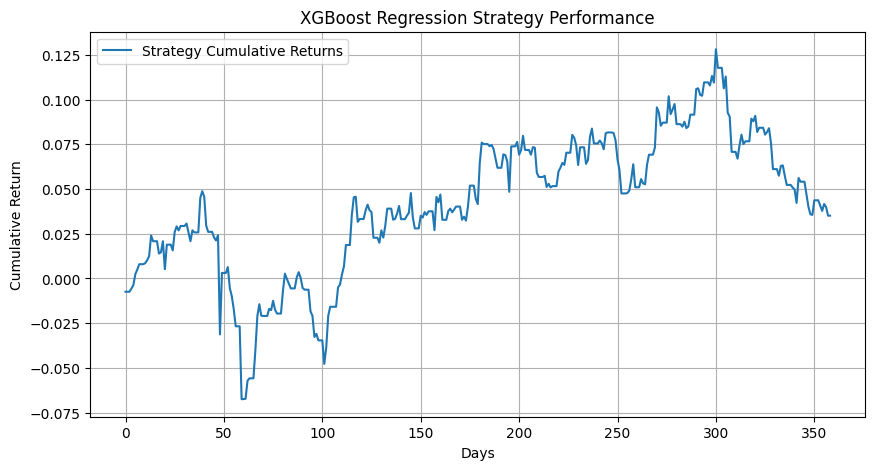

In [ ]:
def evaluate_regression_model(y_true, y_pred, model_name="Model"):
    """
    Evaluate regression model on return predictions using MSE, Sharpe Ratio, and Max Drawdown.
    """
    # === MSE ===
    mse = mean_squared_error(y_true, y_pred)

    # === Strategy Returns ===
    # Strategy: Long if predicted return > 0, Short if < 0
    strategy_returns = np.where(y_pred > 0, y_true, -y_true)

    # === Sharpe Ratio ===
    mean_return = np.mean(strategy_returns)
    std_return = np.std(strategy_returns)
    sharpe_ratio = (mean_return / std_return) * np.sqrt(252)

    # === Max Drawdown ===
    cumulative_returns = np.cumsum(strategy_returns)
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = cumulative_returns - running_max
    max_drawdown = drawdowns.min()

    # === Results ===
    print(f"\n📊 Evaluation Metrics for {model_name}")
    print(f"Test MSE         : {mse:.6f}")
    print(f"Sharpe Ratio     : {sharpe_ratio:.4f}")
    print(f"Max Drawdown     : {max_drawdown:.4f}")

    # Optional: Plot strategy equity curve
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_returns, label='Strategy Cumulative Returns')
    plt.title(f"{model_name} Strategy Performance")
    plt.xlabel('Days')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend()
    plt.show()

    return {
        "Model": model_name,
        "MSE": mse,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }


xgb_eval = evaluate_regression_model(y_test_reg, y_pred_reg, model_name="XGBoost Regression")


A Sharpe Ratio below 0.5 indicates the strategy may not outperform a naive or risk-free strategy.

**Improved XG BOOST Model**

Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost Test MSE: 0.000059
XGBoost R² Score: -0.0077
Strategy Sharpe Ratio: 0.5867
Strategy Max Drawdown: -0.1239


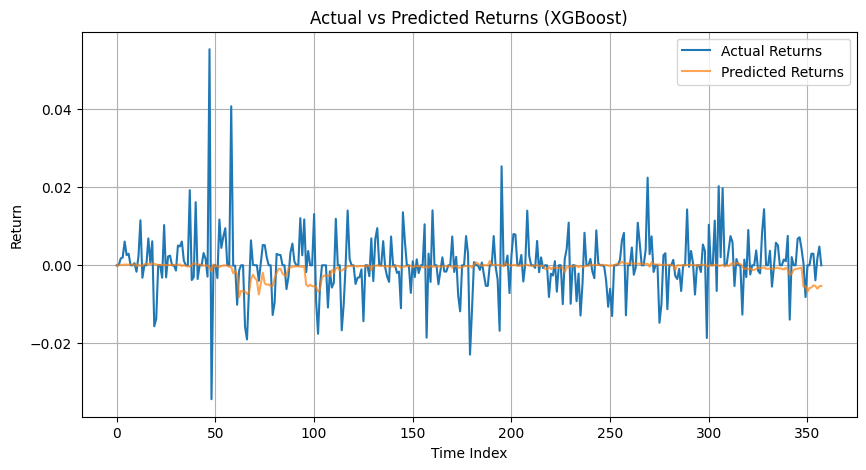

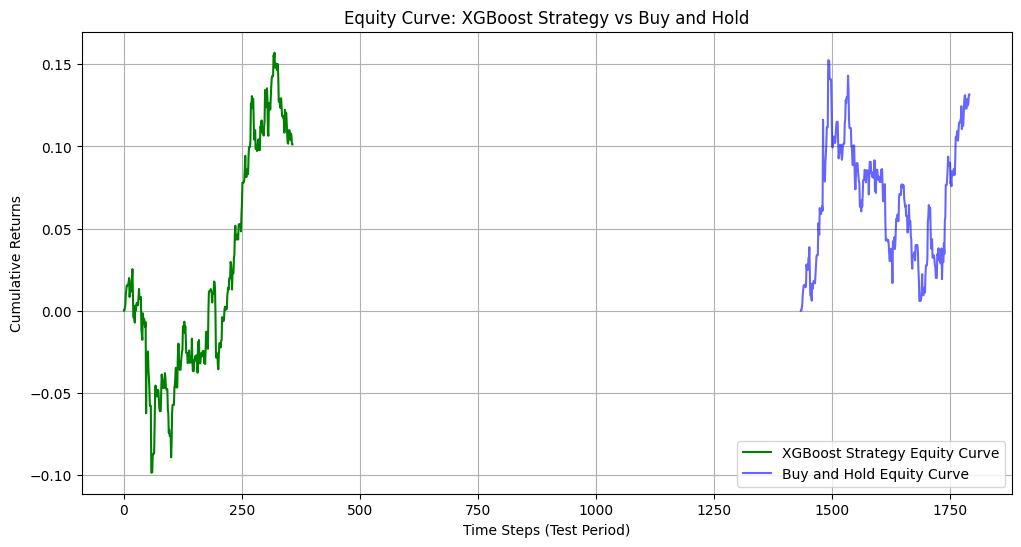

In [ ]:
# Add lag features to capture autocorrelation
df['Return_Lag1'] = df['Return'].shift(1)
df['Return_Lag2'] = df['Return'].shift(2)
df = df.dropna()

# Define features and target
features = df.drop(columns=['Date', 'Price', 'Return', 'Direction'])
target = df['Return']

# Split data for time series (no shuffle)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# ----------------------------------------
# Hyperparameter tuning using RandomizedSearchCV
# ----------------------------------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=20,
                            cv=3, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error')

search.fit(X_train, y_train)
best_model = search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Test MSE: {mse:.6f}")
print(f"XGBoost R² Score: {r2:.4f}")

# ------------------------
# Strategy performance metrics
# ------------------------

# Strategy: Long if prediction > 0, Short if prediction < 0
strategy_returns = np.where(y_pred > 0, y_test, -y_test)

def sharpe_ratio(returns):
    mean_ret = np.mean(returns)
    std_ret = np.std(returns)
    return (mean_ret / std_ret) * np.sqrt(252)

sharpe = sharpe_ratio(strategy_returns)
cumulative_returns = np.cumsum(strategy_returns)
running_max = np.maximum.accumulate(cumulative_returns)
drawdown = cumulative_returns - running_max
max_drawdown = drawdown.min()

print(f"Strategy Sharpe Ratio: {sharpe:.4f}")
print(f"Strategy Max Drawdown: {max_drawdown:.4f}")

# ------------------------
# Plots
# ------------------------

# Predicted vs Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Returns')
plt.plot(y_pred, label='Predicted Returns', alpha=0.7)
plt.title("Actual vs Predicted Returns (XGBoost)")
plt.xlabel("Time Index")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='XGBoost Strategy Equity Curve', color='green')
plt.plot(np.cumsum(y_test), label='Buy and Hold Equity Curve', color='blue', alpha=0.6)
plt.title('Equity Curve: XGBoost Strategy vs Buy and Hold')
plt.xlabel('Time Steps (Test Period)')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


We choose the improved XGBoost model — it’s better in every key metric:

Higher Sharpe → better risk-adjusted performance.

Lower MSE → better return prediction accuracy.

Lower drawdown → less downside risk.

In [ ]:
import pickle
from google.colab import files

# Save the model
with open('XG_Boost_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Download the file to your PC
files.download('XG_Boost_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>